In [264]:
import json
import numpy as np
import pandas as pd
from os import path
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

In [265]:
stories_json = []
with open('./output_storiesv2.json', 'r') as f:
    stories_json = stories_json + json.loads(f.read())

print(len(stories_json))
print(stories_json[1].keys())

407
dict_keys(['index', 'title', 'broadcasting_date', 'abstracts_list'])


In [266]:
stories_df = pd.DataFrame(stories_json)
stories_df = stories_df.explode('abstracts_list')
stories_df.rename(columns={'abstracts_list': 'abstract'}, inplace=True)

stories_df.head()

,index,title,broadcasting_date,abstract
0,0325,春だ！映画だ！３時間アニメ祭り\r\n「映画ドラえもん のび太の新魔界大冒険～７人の魔法使い...,2013年3月15日,何をやってもうまくいかないのび太は、「魔法（まほう）が使えたら便利で楽しくなるにちがいない...
0,0325,春だ！映画だ！３時間アニメ祭り\r\n「映画ドラえもん のび太の新魔界大冒険～７人の魔法使い...,2013年3月15日,★最新作『映画ドラえもん のび太のひみつ道具博物館（ミュージアム）』の寺本幸代監督が、初めて...
1,0326,「ばくはつコショウ」「何が何でもお花見を」[2013年4月12日放送],2013年4月12日,ある朝、ねぼうしたのび太に泣きつかれたドラえもんは、『ばくはつコショウ』を取り出す。このコ...
1,0326,「ばくはつコショウ」「何が何でもお花見を」[2013年4月12日放送],2013年4月12日,みんなから家族でお花見に行った話を聞き、うらやましくてしかたのないのび太。さっそくママにた...
2,0327,「やりクリしてハワイ旅行」「しずかちゃんのはごろも」[2013年4月26日放送],2013年4月26日,スネ夫からハワイ旅行をじまんされたのび太は、自分もハワイに行きたいとママにたのもうとするが...


In [267]:
stories_df['broadcasting_date'] = stories_df['broadcasting_date'].apply(lambda d: datetime.strptime(d, '%Y年%m月%d日'))

In [268]:
t = MeCab.Tagger('-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')
def mecab_tokenizer(text):
    parsed_lines = t.parse(text).split("\n")[:-2]
    surfaces = [l.split('\t')[0] for l in parsed_lines]
    features = [l.split('\t')[1] for l in parsed_lines]
    # 原型を取得
    bases = [f.split(',')[6] for f in features]
    # 品詞を取得
    pos = [f.split(',')[0] for f in features]

    # 各単語を原型に変換する
    token_list = [b if b != '*' else s for s, b in zip(surfaces, bases)]
    # 瀕死を絞り込み
    target_pos = ["名詞"]
    token_list = [t for t, p in zip(token_list, pos) if p in target_pos]
    # アルファベットを小文字に統一
    token_list = [t.lower() for t in token_list]

    return [ text for text in filter(lambda x: not x.isascii(), token_list)]

In [269]:
# ストーリーが取得できたものに絞る
stories_df = stories_df[stories_df['abstract'].str.len() > 0] 
stories_df['abstracts_tokenize'] = stories_df['abstract'].apply(mecab_tokenizer)
stories_df.head()

,index,title,broadcasting_date,abstract,abstracts_tokenize
0,0325,春だ！映画だ！３時間アニメ祭り\r\n「映画ドラえもん のび太の新魔界大冒険～７人の魔法使い...,2013-03-15,何をやってもうまくいかないのび太は、「魔法（まほう）が使えたら便利で楽しくなるにちがいない...,"[何, のび太, 魔法, 魔法, 便利, ちがい, もしもボックス, 現実, 世界, 魔法,..."
0,0325,春だ！映画だ！３時間アニメ祭り\r\n「映画ドラえもん のび太の新魔界大冒険～７人の魔法使い...,2013-03-15,★最新作『映画ドラえもん のび太のひみつ道具博物館（ミュージアム）』の寺本幸代監督が、初めて...,"[最新作, 映画ドラえもん, のび太のひみつ道具博物館, ミュージアム, 寺本幸代, 監督,..."
1,0326,「ばくはつコショウ」「何が何でもお花見を」[2013年4月12日放送],2013-04-12,ある朝、ねぼうしたのび太に泣きつかれたドラえもんは、『ばくはつコショウ』を取り出す。このコ...,"[朝, 寝坊, のび太, ドラえもん, 爆発, コショウ, コショウ, 行き先, そば, 人..."
1,0326,「ばくはつコショウ」「何が何でもお花見を」[2013年4月12日放送],2013-04-12,みんなから家族でお花見に行った話を聞き、うらやましくてしかたのないのび太。さっそくママにた...,"[みんな, 家族, お花見, 話, しかた, のび太, ママ, パパ, ゴルフ, 予定, の..."
2,0327,「やりクリしてハワイ旅行」「しずかちゃんのはごろも」[2013年4月26日放送],2013-04-26,スネ夫からハワイ旅行をじまんされたのび太は、自分もハワイに行きたいとママにたのもうとするが...,"[スネ夫, ハワイ旅行, じまん, のび太, 自分, ハワイ, ママ, 給料日, 前, お金..."


In [270]:
stories_df["doraemon_flag"] = stories_df["abstracts_tokenize"].apply(lambda x: "ドラえもん" in x)
stories_df["nobita_flag"] = stories_df["abstracts_tokenize"].apply(lambda x: "のび太" in x)
stories_df["sizuka_flag"] = stories_df["abstracts_tokenize"].apply(lambda x: "しずか" in x or "しずかちゃん" in x)
stories_df["gian_flag"] = stories_df["abstracts_tokenize"].apply(lambda x: "ジャイアン" in x)
stories_df["suneo_flag"] = stories_df["abstracts_tokenize"].apply(lambda x: "スネ夫" in x)
stories_df["dekisugi_flag"] = stories_df["abstracts_tokenize"].apply(lambda x: "出木杉" in x)

# stories_df.head()

In [271]:
# sns.scatterplot(data=stories_df, x="broadcasting_date", y="sizuka_flag")


In [272]:
stories_df['broadcasting_quarter'] = pd.PeriodIndex(stories_df['broadcasting_date'], freq='Q')
stories_df.head()

,index,title,broadcasting_date,abstract,abstracts_tokenize,doraemon_flag,nobita_flag,sizuka_flag,gian_flag,suneo_flag,dekisugi_flag,broadcasting_quarter
0,0325,春だ！映画だ！３時間アニメ祭り\r\n「映画ドラえもん のび太の新魔界大冒険～７人の魔法使い...,2013-03-15,何をやってもうまくいかないのび太は、「魔法（まほう）が使えたら便利で楽しくなるにちがいない...,"[何, のび太, 魔法, 魔法, 便利, ちがい, もしもボックス, 現実, 世界, 魔法,...",True,True,True,True,True,False,2013Q1
0,0325,春だ！映画だ！３時間アニメ祭り\r\n「映画ドラえもん のび太の新魔界大冒険～７人の魔法使い...,2013-03-15,★最新作『映画ドラえもん のび太のひみつ道具博物館（ミュージアム）』の寺本幸代監督が、初めて...,"[最新作, 映画ドラえもん, のび太のひみつ道具博物館, ミュージアム, 寺本幸代, 監督,...",False,False,False,False,False,False,2013Q1
1,0326,「ばくはつコショウ」「何が何でもお花見を」[2013年4月12日放送],2013-04-12,ある朝、ねぼうしたのび太に泣きつかれたドラえもんは、『ばくはつコショウ』を取り出す。このコ...,"[朝, 寝坊, のび太, ドラえもん, 爆発, コショウ, コショウ, 行き先, そば, 人...",True,True,False,True,False,False,2013Q2
1,0326,「ばくはつコショウ」「何が何でもお花見を」[2013年4月12日放送],2013-04-12,みんなから家族でお花見に行った話を聞き、うらやましくてしかたのないのび太。さっそくママにた...,"[みんな, 家族, お花見, 話, しかた, のび太, ママ, パパ, ゴルフ, 予定, の...",True,True,True,False,False,False,2013Q2
2,0327,「やりクリしてハワイ旅行」「しずかちゃんのはごろも」[2013年4月26日放送],2013-04-26,スネ夫からハワイ旅行をじまんされたのび太は、自分もハワイに行きたいとママにたのもうとするが...,"[スネ夫, ハワイ旅行, じまん, のび太, 自分, ハワイ, ママ, 給料日, 前, お金...",True,True,False,False,True,False,2013Q2


In [273]:
# 年ごとの割合を算出
grouped_stories_sum_df = stories_df['index'].groupby([stories_df['broadcasting_quarter']]).count()
grouped_stories_sum_df = pd.DataFrame(grouped_stories_sum_df)
grouped_stories_sum_df.reset_index(inplace=True)
grouped_stories_sum_df.rename(columns={
    'index': 'total_stories_count'
}, inplace=True)
grouped_stories_sum_df.head()

,broadcasting_quarter,total_stories_count
0,2013Q1,2
1,2013Q2,20
2,2013Q3,19
3,2013Q4,17
4,2014Q1,14


In [274]:
grouped_df = stories_df.groupby([stories_df['broadcasting_quarter']]).sum()
grouped_df.reset_index(inplace=True)
melt_df = pd.melt(grouped_df, id_vars=['broadcasting_quarter'], value_vars=['doraemon_flag', 'nobita_flag', 'sizuka_flag', 'gian_flag', 'suneo_flag', 'dekisugi_flag'])
melt_df.head()

,broadcasting_quarter,variable,value
0,2013Q1,doraemon_flag,1
1,2013Q2,doraemon_flag,20
2,2013Q3,doraemon_flag,19
3,2013Q4,doraemon_flag,17
4,2014Q1,doraemon_flag,14


In [275]:
joined_stories_df = melt_df.merge(grouped_stories_sum_df, on='broadcasting_quarter', how='left')
joined_stories_df['percentage'] = joined_stories_df['value'] / joined_stories_df['total_stories_count']
joined_stories_df.head()


,broadcasting_quarter,variable,value,total_stories_count,percentage
0,2013Q1,doraemon_flag,1,2,0.5
1,2013Q2,doraemon_flag,20,20,1.0
2,2013Q3,doraemon_flag,19,19,1.0
3,2013Q4,doraemon_flag,17,17,1.0
4,2014Q1,doraemon_flag,14,14,1.0


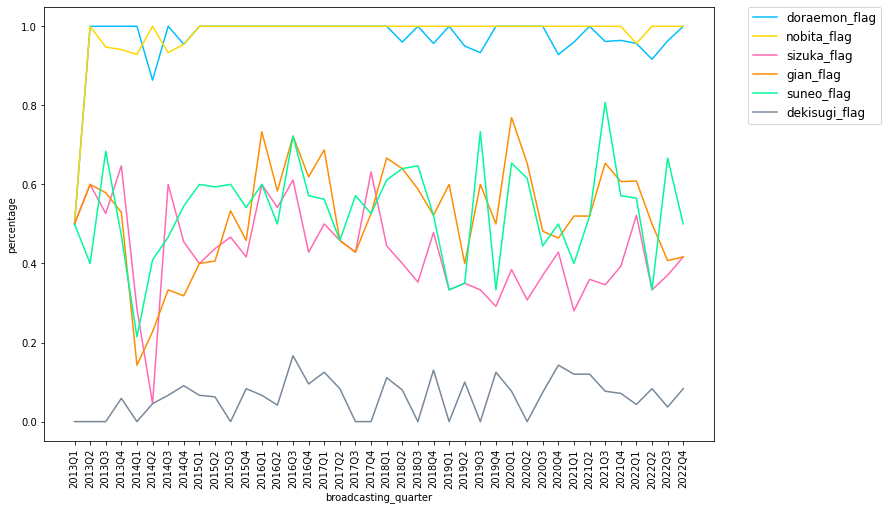

In [276]:
colors = ['#00bfff', '#ffd700', '#ff69b4', '#ff8c00', '#00fa9a', '#778899']

plt.figure(figsize=(12,8))
sns.lineplot(x=joined_stories_df['broadcasting_quarter'].astype(str), y=joined_stories_df['percentage'], hue=joined_stories_df['variable'], palette=sns.color_palette(colors))
plt.legend(bbox_to_anchor=(1.25, 1.0), loc='upper right', borderaxespad=0, fontsize=12)
plt.tick_params(axis='x', labelrotation=90)


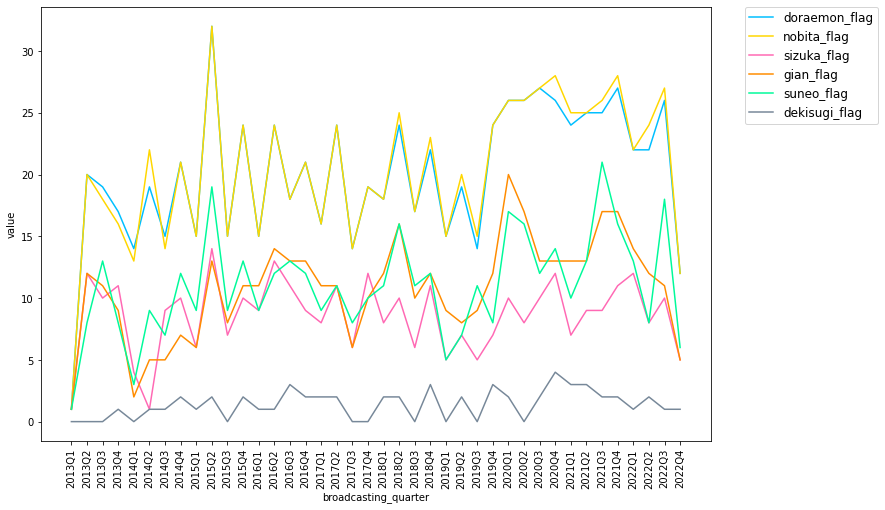

In [277]:
plt.figure(figsize=(12,8))
sns.lineplot(x=joined_stories_df['broadcasting_quarter'].astype(str), y=joined_stories_df['value'], hue=joined_stories_df['variable'], palette=sns.color_palette(colors))
plt.legend(bbox_to_anchor=(1.25, 1.0), loc='upper right', borderaxespad=0, fontsize=12)
plt.tick_params(axis='x', labelrotation=90)
